In [2]:
from sklearn.model_selection import train_test_split

# load and create hold-out set
df = pd.read_csv('numerai_training_data.csv')
df, df_dev = train_test_split(df, test_size=0.1, random_state=7)

# put all data in one object
data = pd.Series({
    'X': df.drop('target', axis=1),
    'y': df[['target']],
    'X_dev': df_dev.drop('target', axis=1),
    'y_dev': df_dev[['target']],
})


In [10]:
import tensorflow as tf

n_samples = data['X'].shape[0]
n_features = data['X'].shape[1]
n_hidden = 5

# input
X = tf.placeholder(dtype=tf.float32, shape=[None, n_features])
y = tf.placeholder(dtype=tf.float32, shape=[None, 1])

# initialize
init = pd.Series()
init['W1'] = tf.random_normal(seed=13, shape=[n_features, n_hidden], dtype=tf.float32,
                              mean=0.0, stddev=np.sqrt(6.0 / n_features / n_hidden))
init['b1'] = tf.constant(0.0, shape=[n_hidden], dtype=tf.float32)
init['W2'] = tf.random_normal(seed=11, shape=[n_hidden, 1], dtype=tf.float32,
                              mean=0.0, stddev=np.sqrt(6.0 / n_hidden))
init['b2'] = tf.constant(data['y']['target'].mean(), shape=[1], dtype=tf.float32)

# weights
W1 = tf.Variable(init['W1'])
b1 = tf.Variable(init['b1'])
W2 = tf.Variable(init['W2'])
b2 = tf.Variable(init['b2'])

# define the network graph
A = tf.sigmoid(tf.matmul(X, W1) + b1)
logits = tf.matmul(A, W2) + b2

# compare against target signal
loss_bare = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits, y))
loss_reg = loss_bare + 1e-4 * sum(map(tf.nn.l2_loss, [W1, b1, W2, b2]))

# optimizer
train = tf.train.AdamOptimizer(1e-3).minimize(loss_reg)


epoch: 1, regularized loss: 0.777295, bare loss: 0.776502, dev loss: 0.694714
epoch: 2, regularized loss: 0.694734, bare loss: 0.693936, dev loss: 0.694440
epoch: 3, regularized loss: 0.694492, bare loss: 0.693696, dev loss: 0.694182
epoch: 4, regularized loss: 0.694236, bare loss: 0.693440, dev loss: 0.693917
epoch: 5, regularized loss: 0.693982, bare loss: 0.693188, dev loss: 0.693662
epoch: 6, regularized loss: 0.693746, bare loss: 0.692953, dev loss: 0.693428
epoch: 7, regularized loss: 0.693534, bare loss: 0.692742, dev loss: 0.693220
epoch: 8, regularized loss: 0.693349, bare loss: 0.692559, dev loss: 0.693040
epoch: 9, regularized loss: 0.693192, bare loss: 0.692403, dev loss: 0.692887
epoch: 10, regularized loss: 0.693060, bare loss: 0.692271, dev loss: 0.692758
epoch: 11, regularized loss: 0.692950, bare loss: 0.692163, dev loss: 0.692649
epoch: 12, regularized loss: 0.692859, bare loss: 0.692073, dev loss: 0.692558
epoch: 13, regularized loss: 0.692783, bare loss: 0.691999, d

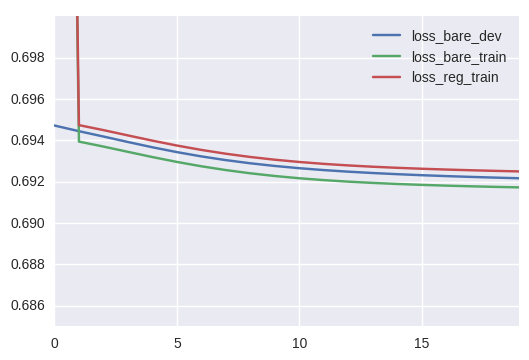

In [14]:
from sklearn.model_selection import StratifiedKFold

n_epochs = 20
n_batches = 100

with tf.Session() as s:
    
    # initialize
    s.run(tf.global_variables_initializer())
    learning_curve = {'loss_reg_train': [], 'loss_bare_train': [], 'loss_bare_dev': []}
    
    # multiple passes over the entire dataset
    for epoch in xrange(1, n_epochs + 1):
        
        # init within epoch
        loss_reg_epoch = 0.0
        loss_bare_epoch = 0.0
        
        # create new splits with every epoch
        cv = StratifiedKFold(n_splits=n_batches, random_state=epoch)
        cv = cv.split(X=data['X'], y=data['y']['target'])
        batches = (batch for _, batch in cv)

        # train on each batch individually
        for idx in batches:
            feed_dict = {X: data.X.iloc[idx], y: data.y.iloc[idx]}
            _, loss_reg_, loss_bare_ = s.run([train, loss_reg, loss_bare], feed_dict)
            loss_reg_epoch += loss_reg_
            loss_bare_epoch += loss_bare_
            
        # cumulative loss -> average loss
        loss_reg_epoch /= n_batches
        loss_bare_epoch /= n_batches

        # loss on dev set
        feed_dict = {X: data.X_dev, y: data.y_dev}
        loss_dev_epoch = s.run(loss_bare, feed_dict)

        # record and print losses
        learning_curve['loss_reg_train'].append(loss_reg_epoch)
        learning_curve['loss_bare_train'].append(loss_bare_epoch)
        learning_curve['loss_bare_dev'].append(loss_dev_epoch)
        print ("epoch: {}, regularized loss: {:6f}, bare loss: {:6f}, dev loss: {:6f}"
               .format(epoch, loss_reg_epoch, loss_bare_epoch, loss_dev_epoch))


pd.DataFrame(learning_curve).plot(ylim=(.685, .7))